## Import Packages and Load in Data

In [3]:
import numpy as np
import pandas as pd
import math
import theano.tensor as tt
import pymc3 as pm
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
scallop = pd.read_csv('scallop.csv',index_col=0)
scallop.head()

,latitude,longitude,tot.catch
1,40.55000,-71.55000,0
2,40.46667,-71.51667,0
3,40.51667,-71.71667,0
4,40.38333,-71.85000,1
5,40.31667,-71.78333,0


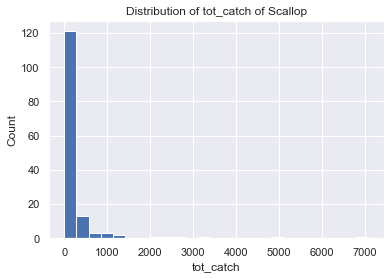

In [5]:
# Histogram of tot.catch
plt.hist(scallop['tot.catch'],bins=25)
plt.xlabel('tot_catch')
plt.ylabel('Count')
plt.title('Distribution of tot_catch of Scallop')
plt.show()

Text(0.5, 1.0, 'Distribution of log(tot.catch+0.25) of Scallop')

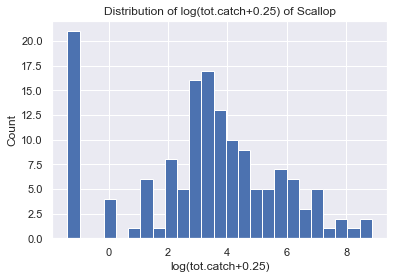

In [6]:
# log(x+0.25) transform of tot.catch (in case of log(0) not defined)
log_y = scallop['tot.catch'].apply(lambda x: np.log(x+0.25))
plt.hist(log_y,bins=25)
plt.xlabel('log(tot.catch+0.25)')
plt.ylabel('Count')
plt.title('Distribution of log(tot.catch+0.25) of Scallop')

After logrithm transformation, the distribution of `tot.catch` seems to be more Gaussian than the original one. However, there are many 0 catches in the dataset. This may suggest that we should assign prior weight mean 0.

Thought: Does Poission regression get a better result?

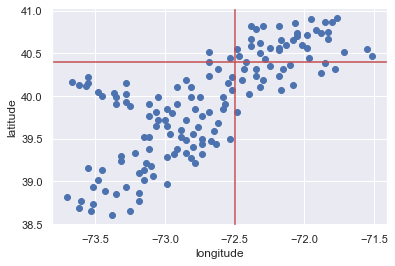

In [7]:
# visualize scatter plot of X1 and X2
X1 = scallop['longitude'].values
X2 = scallop['latitude'].values
plt.scatter(X1,X2)
plt.xlabel('longitude')
plt.ylabel('latitude')
# block the data so as to select the test set
plt.axhline(y=40.4, color='r', linestyle='-') 
plt.axvline(x=-72.5, color='r', linestyle='-') 
plt.show()

In order to gain a more accurate test error (avoid overfitting), block the data and select the records that with `latitude` $> 40.4$ and `longitude` $> -72.5$ to be the test data, and the remaining records are training set.

In [8]:
# test set selection according to the criteria
test = scallop[(scallop['latitude']>40.4) & (scallop['longitude']>-72.5)]
x_test = test[['longitude','latitude']].values
# number of test cases
n_test = test.shape[0]

# design matrix for test set (with a column of 1 added)
X_test = np.append(np.ones(n_test).reshape([n_test,1]),x_test,axis=1)
# original tot.catch for test set
y_test = np.log(test['tot.catch'].values+0.25)

In [9]:
train = scallop[~(scallop['latitude']>40.4) | ~(scallop['longitude']>-72.5)]
x_train = train[['longitude','latitude']].values
# number of training cases
n_train = train.shape[0]

# design matrix for training set (with a column of 1 added)
X_train = np.append(np.ones(n_train).reshape([n_train,1]),x_train,axis=1)
# log transformed tot.catch for training set
y_train =  np.log(train['tot.catch'].values+0.25)

# Weight-space View

Likelihood: $p(y|X, \beta) = \prod_{i=1}^{n} p(y_i|x_i, \beta) = {(2\pi \sigma_n^2)^{-n/2}} \exp\left(-\frac{1}{2\sigma_n^2}||y - X^T \beta||^2\right) = N(X^T \beta, \sigma_n^2 I)$, 
where in our case, $y_i$ is `log(tot.catch+0.25)`, $x_i$ is a vector containing `latitude` and `longitude` values, as well as a value $1$ prepared for intercept, and $\beta$ is the weight vector, including $\beta_0$, $\beta_1$, $\beta_2$. $X$ is the design matrix, which has observation as rows.

## Prior Distribution
I set a mutivariate normal distribution with zero mean for the weight vector $\beta$. Its covariance is denoted as $sigma\_p$.

In [10]:
d = 3

# Mean vector
mu_0 = np.zeros(d)

# Covariance matrix
# Add small value for numerical stability
# large variance b/c I barely have prior knowledge of the weights
sigma_p = np.array([[1e6,1,1], [1,1e6,1],[1,1,1e6]]) + 1e-12*np.eye(d)
print(sigma_p)

[[1.e+06 1.e+00 1.e+00]
 [1.e+00 1.e+06 1.e+00]
 [1.e+00 1.e+00 1.e+06]]


## MCMC Simulation

In [11]:
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.8


In [12]:
import theano
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"

In [31]:
model = pm.Model()

with model:
    # prior
    beta = pm.MvNormal('beta', mu=mu_0, cov=sigma_p, shape=d) # prior for beta
    sig_n = pm.InverseGamma('sigma_n', alpha=5, beta=5) # prior for sigma_n
    
    # likelihood
    likelihood = pm.Normal('y', mu=tt.dot(X_train, beta), sd=sig_n, observed=y_train.squeeze())
    trace = pm.sample(draws=8000,chains=2,tune=800)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma_n, beta]
Sampling 2 chains, 0 divergences: 100%|██████████| 17600/17600 [16:00<00:00, 18.32draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


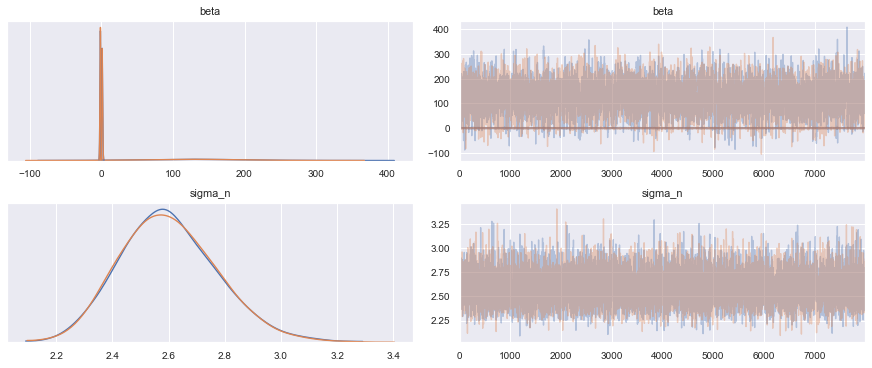

In [32]:
import warnings
warnings.filterwarnings('ignore')

pm.traceplot(trace,figsize=(12, 5),compact=True)
plt.show()

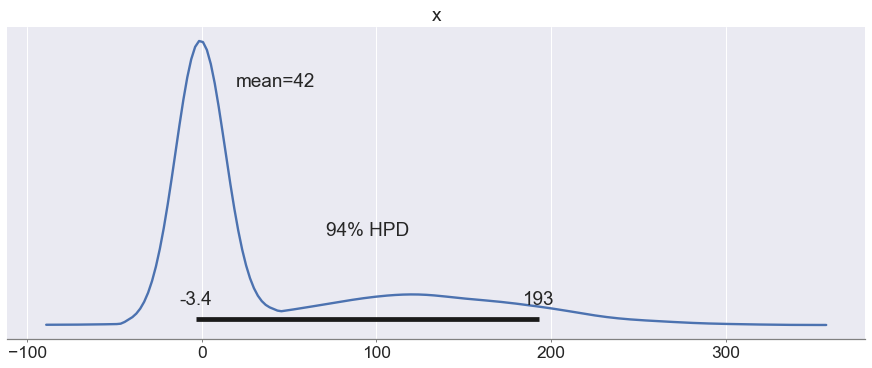

In [34]:
# posterior plot for beta_0
pm.plot_posterior(trace['beta'].reshape([3,16000])[0], figsize=(12, 5))
plt.show()

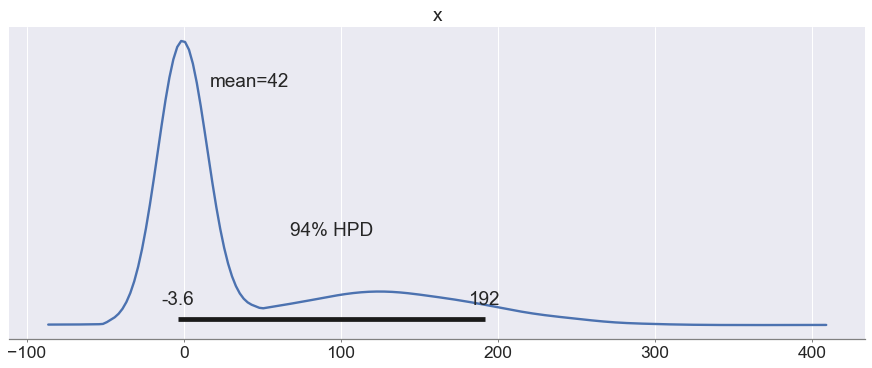

In [35]:
# posterior plot for beta_1
pm.plot_posterior(trace['beta'].reshape([3,16000])[1], figsize=(12, 5))
plt.show()

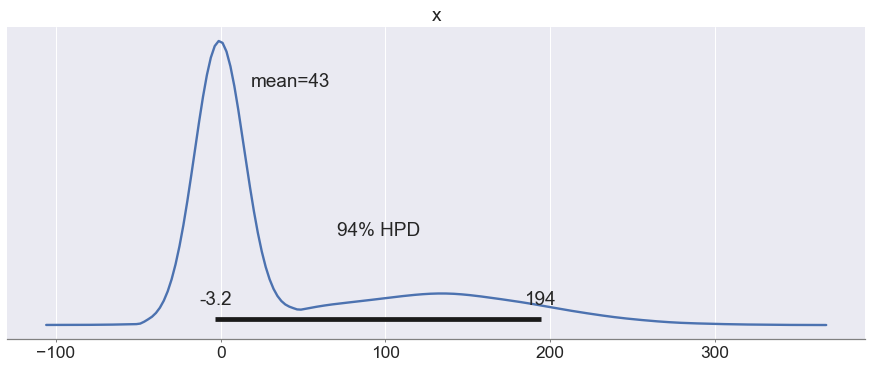

In [36]:
# posterior plot for beta_2
pm.plot_posterior(trace['beta'].reshape([3,16000])[2], figsize=(12, 5))
plt.show()

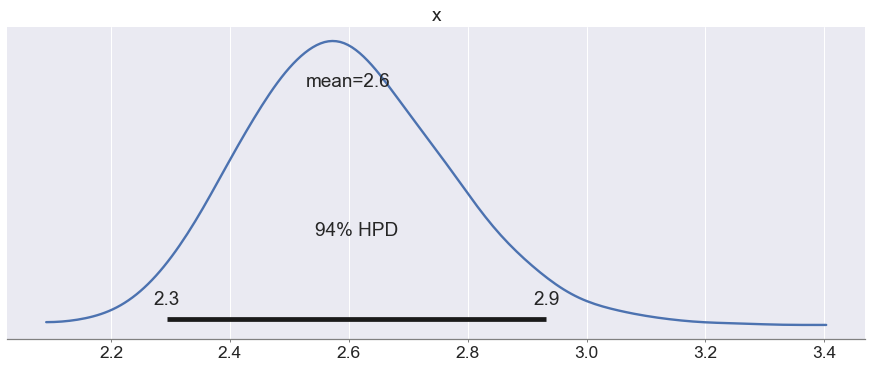

In [37]:
# posterior plot for sigma_n
pm.plot_posterior(trace['sigma_n'], figsize=(12, 5))
plt.show()

In [38]:
summary_tab = pm.summary(trace)
summary_tab

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta[0],127.199,65.359,2.430,250.083,0.961,0.691,4622.0,4473.0,4623.0,5108.0,1.0
beta[1],0.909,0.680,-0.419,2.148,0.010,0.007,4964.0,4813.0,4965.0,6002.0,1.0
beta[2],-1.450,0.581,-2.521,-0.326,0.008,0.006,5792.0,5535.0,5794.0,6922.0,1.0
sigma_n,2.599,0.172,2.294,2.932,0.002,0.001,7071.0,6984.0,7212.0,7964.0,1.0


In [39]:
summary_tab['sd']/abs(summary_tab['mean'])

beta[0]    0.513833
beta[1]    0.748075
beta[2]    0.400690
sigma_n    0.066179
dtype: float64

From the trace summary, we can see the mean for each beta's posterior distribution. Standard deviation for $\beta_0$ is very large, suggesting an unstable estimation. 94% HPD (Highest Posterior Density) is the credible intervel for the parameters. HPD for $\beta_1$ cover point 0, suggesting that we are not sure if the it is positive or negative. 

According to my research, we can use **r_hat** to verify the convergence. **r_hat** close to 1.0 means convergence.

**Posterior mean in analytical form**

$\beta|X, y \sim N(\sigma^{-2}_n A X y, A^{-1})$, 

where $A = \sigma^{-2}_n X X^{T} + \Sigma_p$

In [40]:
post_mean_sig = summary_tab['mean'][3]
A = (1/post_mean_sig**2)*np.dot(X_train.T,X_train)+np.linalg.inv(sigma_p)
(1/post_mean_sig**2)*np.dot(np.linalg.inv(A),np.dot(X_train.T,y_train))

array([127.16200425,   0.9085143 ,  -1.45041431])

## Model Checking

In [41]:
beta_0 = summary_tab['mean'][0]
beta_1 = summary_tab['mean'][1]
beta_2 = summary_tab['mean'][2]
beta = np.array([beta_0,beta_1,beta_2])
y_hat = np.dot(X_train,beta)
residual = y_hat-y_train

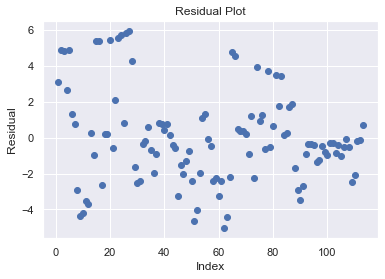

In [42]:
# to see if the observations are dependent
f1 = plt.figure(1)
plt.subplot(111)
plt.scatter(range(1,len(residual)+1),residual)
plt.title('Residual Plot')
plt.xlabel('Index')
plt.ylabel('Residual')
plt.show()

We don't see pattern or trend here. The plot looks fine.

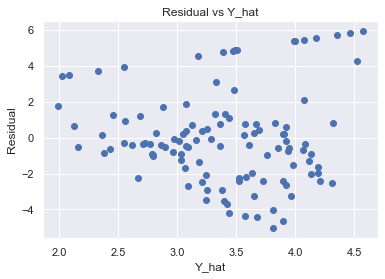

In [43]:
# to see if there exist non-constant variance and non-linearity
f1 = plt.figure(1)
plt.subplot(111)
plt.scatter(x=y_hat,y=residual)
plt.title('Residual vs Y_hat')
plt.xlabel('Y_hat')
plt.ylabel('Residual')
plt.show()

The plot looks fine. But there seems to be a upward trend..

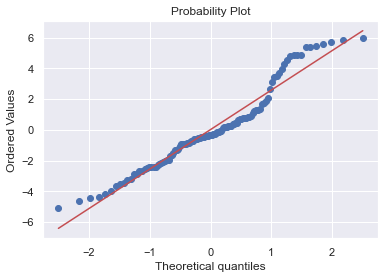

In [44]:
# to see if the normality assumption is violated
from scipy import stats
stats.probplot(residual, dist="norm", plot=plt)
plt.show()

The plot seems reasonable, but there are some points are not so normal. It's expected, because there are many 0s in `tot.catch`.

## Test Set

1. Generate prediction by sampling

In [45]:
def generate_prediction(x_star, trace):

    # Compute prediction distribution
    pred = np.dot(x_star.T, trace['beta'].T)
    # Sample from it
    y_hat = np.random.choice(a=pred.squeeze())
    
    return y_hat

In [51]:
np.random.seed(456)
y_hat_test = []
for i in X_test:
    y_hat_test.append(generate_prediction(i, trace))
y_hat_test = np.array(y_hat_test)

# RMSE for test set
np.sqrt(np.square(y_hat_test - y_test).sum())

12.535469518366522

2. Generate prediction using simulated posterior mean

In [47]:
beta_0 = summary_tab['mean'][0]
beta_1 = summary_tab['mean'][1]
beta_2 = summary_tab['mean'][2]
beta = np.array([beta_0,beta_1,beta_2])
y_hat_test2 = np.dot(X_test,beta)

In [48]:
# RMSE for test set
np.sqrt(np.square(y_hat_test2 - y_test).sum())

12.761171077989577